In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image



%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Denoising

In [3]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [4]:
data, attrs = fetch_dataset()

images not found, donwloading...


--2023-05-04 19:28:36--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘tmp.tgz’

     0K .......... .......... .......... .......... ..........  0%  531K 3m20s
    50K .......... .......... .......... .......... ..........  0% 1.04M 2m30s
   100K .......... .......... .......... .......... ..........  0% 45.5M 1m40s
   150K .......... .......... .......... .......... ..........  0% 1.06M 1m40s
   200K .......... .......... .......... .......... ..........  0% 42.1M 80s
   250K .......... .......... .......... .......... ..........  0% 60.3M 67s
   300K .......... .......... .......... .......... ..........  0%  135M 58s
   350K .......... .......... .......... .......... ..........  0% 1.07M 62s
   400K .......... .

extracting...
lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg
lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg
lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg
lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg
lfw-deepfunneled/Aaron_Patterson/Aaron_Patterson_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0002.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0004.jpg
lfw-deepfunneled/Aaron_Pena/Aaron_Pena_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0002.jpg
lfw-deepfunneled/Aaron_Tippin/Aaron_Tippin_0001.jpg
lfw-deepfunneled/Abba_Eban/Abba_Eban_0001.jpg
lfw-deepfunneled/Abbas_Kiarostami/Abbas_Kiarostami_0001.jpg
lfw-deepfunneled/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg
lfw-deepfunneled/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg
lfw-deepfunneled/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg
lfw-deepfunneled

--2023-05-04 19:28:41--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2023-05-04 19:28:41--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

     0K .......... .......... .......... .......... ..........  0%  855K 17s
    50K .......... .......... .......... .......... ..........  0% 1.79M 12s
   100K .......... .......... .......... .......... ..........  1% 60.6M 8s
   150K .......... .......... .......... 

done


In [5]:
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152


In [6]:
IMAGEX = 64
IMAGEY = 64

y_trans = list(map(lambda x: x.transpose(2, 0, 1), data))
y_torch = torch.FloatTensor(y_trans)

/tmp/ipykernel_31/565594021.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  y_torch = torch.FloatTensor(y_trans)


In [7]:
noise_factor = 0.5
data_noisy = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)

noisy_trans = list(map(lambda x: x.transpose(2, 0, 1), data_noisy))
noisy_torch = torch.FloatTensor(noisy_trans)

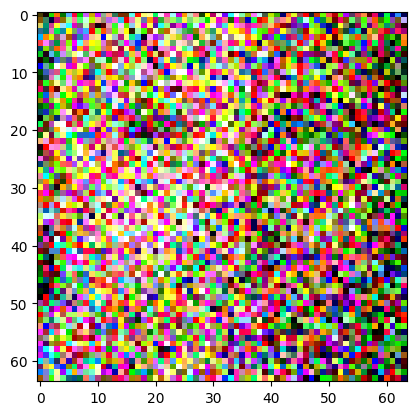

In [8]:
plt.imshow(data_noisy[0])

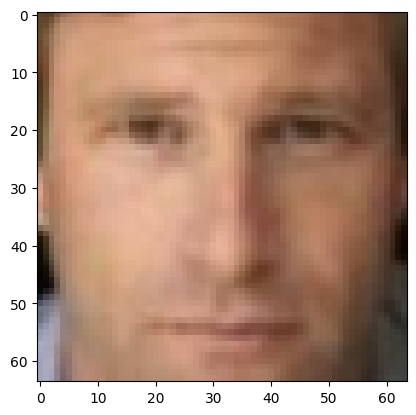

In [9]:
plt.imshow(data[0])

In [10]:
dataset = list(map(lambda x,y: (x,y), noisy_torch, y_torch))
trainset, valset = train_test_split(dataset, train_size = 0.9)

dataloader = {
    'train': DataLoader(trainset, batch_size=16, shuffle=True, drop_last=True),
    'valid': DataLoader(valset, batch_size=16),
}

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста", 
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

        #encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2, padding=1),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(0.5),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            
            nn.Flatten(),
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.Unflatten(-1, (16, 4, 4)),
            
            nn.Conv2d(in_channels=16, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0),
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=(3, 3), padding=0),

            nn.Sigmoid(),
        )

    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logsigma>
#         print("latent", self.encoder(x).shape)
        # (32, 128)
        latent = self.encoder(x)
#         print("latent", latent.shape)
#         mu = latent[:,0,:] # the first feature values as mean
#         logsigma = latent[:,1,:] # the other feature values as variance
    
#         return mu, logsigma
        return latent
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        reconstruction = self.decoder(z)
        
        return reconstruction

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
#         mu, logsigma = self.encode(x) # the other feature values as variance
        z = self.encode(x)
#         z = self.gaussian_sampler(mu, logsigma)
#         print('z', z.shape)
        reconstruction = self.decode(z)
#         print('rec', reconstruction.shape)

#         return mu, logsigma, reconstruction
        return reconstruction


In [12]:
# criterion = VAELoss()
criterion = nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [13]:
def train(model,optimizer,criterion,train_data,val_data, epochs = 5, device = 'cpu'):
  val_noisy, val_real = next(iter(val_data))
#   val_data, val_labels = torch.FloatTensor(val_data),torch.FloatTensor(val_labels)

  train_losses = []
  val_losses = []
  progress = tqdm(range(epochs), desc='Epoch')
  for epoch in progress:
    for batch in train_data:
      noisy = batch[0].to(device)
      real = batch[1].to(device)
      model.train()
      optimizer.zero_grad()
      
#       mu, logsigma, reconstruction = model(noisy.to(device))
      reconstruction = model(noisy)
#       print(noisy.shape)
#       loss = criterion(real.to(device), mu, logsigma, reconstruction)
      loss = criterion(real, reconstruction)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      
    with torch.no_grad():
      model.eval()
#       val_mu, val_logsigma, val_reconstruction = model(val_noisy.to(device))
      val_reconstruction = model(val_noisy.to(device))
      # val_imgs.append(reconstruction)
      loss = criterion(val_real.to(device), val_reconstruction)
      # print(loss)
      val_losses.append(loss.cpu())
      
    print('\n',"train loss:", train_losses[-1].cpu().detach().numpy(),' valid loss:', val_losses[-1].cpu().detach().numpy())

  # return train_losses, val_losses

In [14]:
for i in range(6):
    train(autoencoder, optimizer, criterion, dataloader['train'], dataloader['valid'], device = device)

Epoch:  20%|██        | 1/5 [00:14<00:58, 14.54s/it]


 train loss: 0.008348902  valid loss: 0.010711564


Epoch:  40%|████      | 2/5 [00:24<00:35, 11.94s/it]


 train loss: 0.0091655245  valid loss: 0.008938811


Epoch:  60%|██████    | 3/5 [00:34<00:22, 11.05s/it]


 train loss: 0.008351619  valid loss: 0.008154707


Epoch:  80%|████████  | 4/5 [00:44<00:10, 10.65s/it]


 train loss: 0.008019266  valid loss: 0.008413817


Epoch: 100%|██████████| 5/5 [00:54<00:00, 10.98s/it]



 train loss: 0.008406629  valid loss: 0.007741237


Epoch:  20%|██        | 1/5 [00:10<00:40, 10.17s/it]


 train loss: 0.0063533  valid loss: 0.007284


Epoch:  40%|████      | 2/5 [00:20<00:30, 10.22s/it]


 train loss: 0.008371163  valid loss: 0.0076888315


Epoch:  60%|██████    | 3/5 [00:30<00:20, 10.32s/it]


 train loss: 0.0056444905  valid loss: 0.0066227624


Epoch:  80%|████████  | 4/5 [00:41<00:10, 10.40s/it]


 train loss: 0.006950747  valid loss: 0.0064025074


Epoch: 100%|██████████| 5/5 [00:51<00:00, 10.40s/it]



 train loss: 0.008427611  valid loss: 0.006244795


Epoch:  20%|██        | 1/5 [00:10<00:42, 10.57s/it]


 train loss: 0.0055216234  valid loss: 0.006963509


Epoch:  40%|████      | 2/5 [00:20<00:31, 10.48s/it]


 train loss: 0.004844354  valid loss: 0.005777444


Epoch:  60%|██████    | 3/5 [00:31<00:20, 10.41s/it]


 train loss: 0.006126143  valid loss: 0.006216041


Epoch:  80%|████████  | 4/5 [00:41<00:10, 10.40s/it]


 train loss: 0.005449321  valid loss: 0.0056865234


Epoch: 100%|██████████| 5/5 [00:52<00:00, 10.41s/it]



 train loss: 0.005815146  valid loss: 0.0056302715


Epoch:  20%|██        | 1/5 [00:10<00:41, 10.39s/it]


 train loss: 0.0050376924  valid loss: 0.0056741885


Epoch:  40%|████      | 2/5 [00:20<00:31, 10.44s/it]


 train loss: 0.004538915  valid loss: 0.0056746635


Epoch:  60%|██████    | 3/5 [00:31<00:20, 10.44s/it]


 train loss: 0.0054641366  valid loss: 0.0052175326


Epoch:  80%|████████  | 4/5 [00:41<00:10, 10.43s/it]


 train loss: 0.0057940623  valid loss: 0.0055348515


Epoch: 100%|██████████| 5/5 [00:52<00:00, 10.43s/it]



 train loss: 0.005027133  valid loss: 0.00552343


Epoch:  20%|██        | 1/5 [00:10<00:41, 10.39s/it]


 train loss: 0.0046434896  valid loss: 0.0057680914


Epoch:  40%|████      | 2/5 [00:20<00:31, 10.39s/it]


 train loss: 0.0057348064  valid loss: 0.0053747073


Epoch:  60%|██████    | 3/5 [00:31<00:20, 10.41s/it]


 train loss: 0.0048764753  valid loss: 0.0058211302


Epoch:  80%|████████  | 4/5 [00:41<00:10, 10.41s/it]


 train loss: 0.0050856564  valid loss: 0.0049810307


Epoch: 100%|██████████| 5/5 [00:52<00:00, 10.41s/it]



 train loss: 0.004852487  valid loss: 0.0053231847


Epoch:  20%|██        | 1/5 [00:10<00:41, 10.50s/it]


 train loss: 0.0046317424  valid loss: 0.005210051


Epoch:  40%|████      | 2/5 [00:20<00:31, 10.47s/it]


 train loss: 0.005291789  valid loss: 0.00501701


Epoch:  60%|██████    | 3/5 [00:31<00:20, 10.44s/it]


 train loss: 0.005189962  valid loss: 0.005076654


Epoch:  80%|████████  | 4/5 [00:41<00:10, 10.47s/it]


 train loss: 0.0046297237  valid loss: 0.005047528


Epoch: 100%|██████████| 5/5 [00:52<00:00, 10.46s/it]


 train loss: 0.0049502566  valid loss: 0.004870376


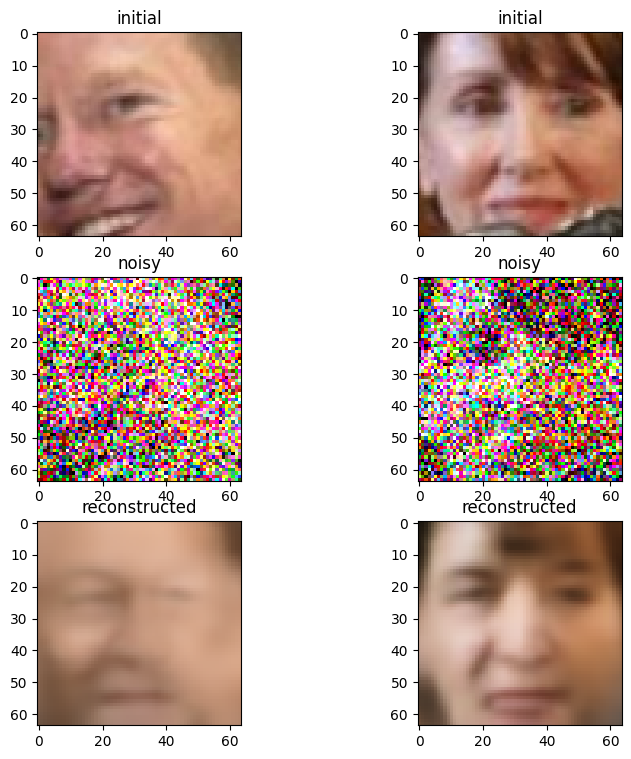

In [15]:
fig = plt.figure(figsize=(9, 9))
axes = fig.subplots(nrows=3, ncols=2)

batch = next(iter(dataloader['valid']))
noisy, real = batch[0].to(device), batch[1].to(device)
reconstructions = autoencoder(noisy)

for i in range(len(batch[:6])):
  axes[0, i].imshow(real[i].cpu().numpy().transpose(1,2,0))
  axes[0, i].set_title('initial')
    
  axes[1, i].imshow(noisy[i].cpu().numpy().transpose(1,2,0))
  axes[1, i].set_title('noisy')

  img_recon = reconstructions[i] 
  axes[2, i].imshow(img_recon.cpu().detach().numpy().transpose(1,2,0))
  axes[2, i].set_title('reconstructed')